In [5]:
from pandas import read_csv,DataFrame,read_excel, merge,concat, Series
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
datacsv          = "peru_ap17/"
list_csv         = os.listdir(datacsv)

baseline = read_csv(datacsv+"OD_baseline_Peru.csv")
baseline.index = baseline.Name

# Initial analysis: selection of links

In [8]:
if os.path.exists("costs_peru_ap22.csv"):
    costs_all = read_csv("costs_peru_ap22.csv")
else:
    costs_all = DataFrame(columns=["scenarioID","diff ruc from baseline (%)","diff ruc from baseline (usd)",\
                               "missingroutes",\
                               "number of affected routes","av cost with traffic (usd)",\
                               "max cost with traffic (%)","max cost with traffic (usd)",\
                               "av km difference","max km difference","tot km difference"])
    for file in list_csv:
        if ".csv" not in file:
            continue
        if file=="OD_baseline_Peru.csv":
            continue
        if "Partial" in file:
            continue
        scenar = read_csv(datacsv+file)
        scenar.index = scenar.Name
        n      = int(re.search('OD_scenario(.*).csv', file).group(1))
        ruc    = scenar.Total_Ta_r.sum()
        voc    = scenar.Total_Ta_v.sum()
        missingroutes = len(baseline)-len(scenar)
        baseline_nomissingroutes = baseline.ix[[i in scenar.index for i in baseline.index],:]
        diff_from_baseline = 100*(ruc/baseline_nomissingroutes.Total_Ta_r.sum()-1)
        diff_from_baseline_abs = ruc-baseline_nomissingroutes.Total_Ta_r.sum()
        diff_km_from_baseline  = scenar.Total_KM.sum()-baseline_nomissingroutes.Total_KM.sum()
        diff_km = scenar.Total_KM - baseline_nomissingroutes.Total_KM
        affected_routes = np.round(scenar.Total_Ta_r/baseline_nomissingroutes.Total_Ta_r,3)!=1
        af_cost = 100*(scenar.ix[affected_routes,"Total_Ta_r"]*baseline_nomissingroutes.ix[affected_routes,"avg_TPDA"]\
        /(baseline_nomissingroutes.ix[affected_routes,"Total_Ta_r"]*baseline_nomissingroutes.ix[affected_routes,"avg_TPDA"])-1)
        af_cost_abs = scenar.ix[affected_routes,"Total_Ta_r"]*baseline_nomissingroutes.ix[affected_routes,"avg_TPDA"]\
        -(baseline_nomissingroutes.ix[affected_routes,"Total_Ta_r"]*baseline_nomissingroutes.ix[affected_routes,"avg_TPDA"])

        costs_all.loc[len(costs_all),:] = [n,diff_from_baseline,diff_from_baseline_abs,\
                                   missingroutes,sum(affected_routes),\
                                   np.mean(af_cost_abs),np.max(af_cost),np.max(af_cost_abs),\
                                  np.mean(diff_km),np.max(diff_km),diff_km_from_baseline]

    costs_all.to_csv("costs_peru_ap22.csv",index=False)

here I merge the info that CJ sent with the results of the analysis (calculation of disruption costs)

In [3]:
info_links = read_excel(datacsv+"Traffic_Link_Final.xlsx","Traffic_Link_Final")

In [10]:
allinfo = merge(info_links, costs_all.rename(columns={"scenarioID":"ScenarioID"}), on='ScenarioID', how='inner')
allinfo.index=allinfo.ScenarioID

(-50, 600)

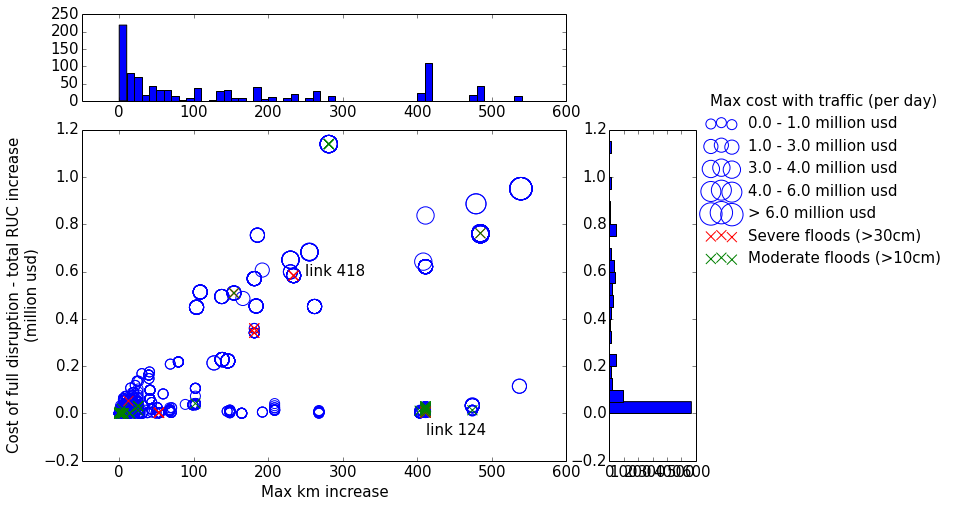

In [11]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(11,8))

x = allinfo["max km difference"]
y = 10**(-6)*allinfo["diff ruc from baseline (usd)"]
z = allinfo['max cost with traffic (usd)']

axScatter = plt.subplot(111)
#axScatter.scatter(x,y,s=10**(-4)*costs['max cost with traffic (usd)'],facecolors='none',edgecolors='blue')
binsz = np.linspace(z.min(), z.max(), 5)
grouped = allinfo.groupby(np.digitize(z, binsz))

# Create some sizes and some labels.
sizes = [100*(i+1.) for i in range(5)]
forleg = np.round(binsz*10**(-6))
labels = ["{} - {} million usd".format(forleg[i],forleg[i+1]) for i in range(4)]+["> {} million usd".format(forleg[4])]

for i, (name, group) in enumerate(grouped):
    axScatter.scatter(group["max km difference"], 10**(-6)*group["diff ruc from baseline (usd)"], \
                      s=sizes[i], alpha=1, label=labels[i],facecolors='none',edgecolors='blue')

select = allinfo["EU_historical_RP100 (cm)"]>30
axScatter.scatter(x[select],y[select],marker="x",s=100,c="red",label="Severe floods (>30cm)")

select2 = (allinfo["EU_historical_RP100 (cm)"]>10)&(allinfo["EU_historical_RP100 (cm)"]<30)
axScatter.scatter(x[select2],y[select2],marker="x",s=100,c="green",label="Moderate floods (>10cm)")
    
plt.xlabel("Max km increase")
plt.ylabel("Cost of full disruption - total RUC increase\n(million usd)")
#axScatter.set_aspect(1.)

# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", size=1.2, pad=0.4, sharex=axScatter)
axHisty = divider.append_axes("right", size=1.2, pad=0.6, sharey=axScatter)

# the scatter plot:
# histograms
binsx = np.arange(x.min(), x.max() + 10, 10)
binsy = np.arange(y.min(), y.max() + 0.05, 0.05)
axHistx.hist(x, bins=binsx)
axHisty.hist(y, bins=binsy, orientation='horizontal')

axScatter.legend(bbox_to_anchor=[1.3,0.65,0.5,0.5],frameon=False,fontsize=15,title="Max cost with traffic (per day)")

axScatter.annotate("link 124",xy=(x[124],y[124]-0.12))
axScatter.annotate("link 418",xy=(x[418]+15,y[418]+0.0))

axScatter.set_xlim([-50,600])

#plt.savefig("all_costs_hist.png",bbox_inches="tight",dpi=400)

# Second part: calculation of expected annual losses

In [3]:
info_links = read_excel(datacsv+"Traffic_Link_Final_only4.xlsx","Traffic_Link_Final")
info_links.index=info_links.ScenarioID

In [5]:
costs_all = read_csv("costs_peru_ap22.csv")
costs_all.index = costs_all.scenarioID

In [272]:
costs_all.loc[[124,418],:].to_csv("table1.csv")

below I calculate the disruption costs linked to a partial disruption

In [8]:
def get_partial_costs(smallrucincrease):
    partial_costs = DataFrame(columns=["scenarioID","diff ruc from baseline (%)","diff ruc from baseline (usd)",\
                               "missingroutes",\
                               "number of affected routes","av cost with traffic (usd)",\
                               "max cost with traffic (%)","max cost with traffic (usd)",\
                               "av km difference","max km difference","tot km difference"])

    for n in list_of_links:
        if smallrucincrease==0:
            scenar = read_csv(datacsv+"Scenario_OD{}_Partial_V2.csv".format(n))
        else:
            scenar = read_csv(datacsv+"Scenario_OD{}_Partial.csv".format(n))
        scenar.index = scenar.Name
        ruc    = scenar.Total_Ta_r.sum()
        voc    = scenar.Total_Ta_v.sum()
        missingroutes = len(baseline)-len(scenar)
        baseline_nomissingroutes = baseline.ix[[i in scenar.index for i in baseline.index],:]
        diff_from_baseline = 100*(ruc/baseline_nomissingroutes.Total_Ta_r.sum()-1)
        diff_from_baseline_abs = ruc-baseline_nomissingroutes.Total_Ta_r.sum()
        diff_km_from_baseline  = scenar.Total_KM.sum()-baseline_nomissingroutes.Total_KM.sum()
        diff_km = scenar.Total_KM - baseline_nomissingroutes.Total_KM
        affected_routes = np.round(scenar.Total_Ta_r/baseline_nomissingroutes.Total_Ta_r,3)!=1
        af_cost = 100*(scenar.ix[affected_routes,"Total_Ta_r"]*baseline_nomissingroutes.ix[affected_routes,"avg_TPDA"]\
        /(baseline_nomissingroutes.ix[affected_routes,"Total_Ta_r"]*baseline_nomissingroutes.ix[affected_routes,"avg_TPDA"])-1)
        af_cost_abs = scenar.ix[affected_routes,"Total_Ta_r"]*baseline_nomissingroutes.ix[affected_routes,"avg_TPDA"]\
        -(baseline_nomissingroutes.ix[affected_routes,"Total_Ta_r"]*baseline_nomissingroutes.ix[affected_routes,"avg_TPDA"])

        partial_costs.loc[len(partial_costs),:] = [n,diff_from_baseline,diff_from_baseline_abs,\
                                   missingroutes,sum(affected_routes),\
                                   np.mean(af_cost_abs),np.max(af_cost),np.max(af_cost_abs),\
                                  np.mean(diff_km),np.max(diff_km),diff_km_from_baseline]
    partial_costs.index = partial_costs.scenarioID
    return partial_costs

In [298]:
info_links.columns

Index(['ScenarioID', 'NAME_0', 'STATUS', 'INTERVEN', 'CLASS', 'LANES', 'TPDA', 'OD', 'CODIGO', 'CORR_ID', 'KM', 'TID', 'pop', 'CITY_NAME', 'ADMIN_NAME', 'CNTRY_NAME', 'STATUS.1', 'TERRAIN', 'SURFACE1', 'COND1', 'TRAFFIC', 'Ta_ruc', 'Ta_voc', 'OPTIMAL', 'EU_historical_RP5 (cm)', 'EU_historical_RP10 (cm)', 'EU_historical_RP25 (cm)', 'EU_historical_RP50 (cm)', 'EU_historical_RP100 (cm)', 'EU_historical_RP250 (cm)', 'EU_historical_RP500 (cm)', 'EU_historical_RP1000 (cm)', 'GFDL_8.5_RP5 (cm)', 'GFDL_8.5_RP10 (cm)', 'GFDL_8.5_RP25 (cm)', 'GFDL_8.5_RP50 (cm)', 'GFDL_8.5_RP100 (cm)', 'GFDL_8.5_RP250 (cm)', 'GFDL_8.5_RP500 (cm)', 'GFDL_8.5_RP1000 (cm)', 'HadGEM2_8.5_RP5 (cm)', 'HadGEM2_8.5_RP10 (cm)', 'HadGEM2_8.5_RP25 (cm)', 'HadGEM2_8.5_RP50 (cm)', 'HadGEM2_8.5_RP100 (cm)', 'HadGEM2_8.5_RP250 (cm)', 'HadGEM2_8.5_RP500 (cm)', 'HadGEM2_8.5_RP1000 (cm)', 'IPSL_8.5_RP5 (cm)', 'IPSL_8.5_RP10 (cm)', 'IPSL_8.5_RP25 (cm)', 'IPSL_8.5_RP50 (cm)', 'IPSL_8.5_RP100 (cm)', 'IPSL_8.5_RP250 (cm)', 'IPSL_8.5_

In [10]:
def choose_costs(costs_all,partial_costs_all,col,indexes):
    if type(indexes)==int:
        indexes = [indexes]
    all_costs = DataFrame(columns=['full_disruption','partial_disruption'])
    all_costs['full_disruption'] = costs_all.loc[indexes,col]
    all_costs['partial_disruption'] = partial_costs_all.loc[indexes,col]
    return all_costs

The function below creates the step function between water level and % of traffic redirected to the second best road

In [11]:
def steps(cm,redirection):
    if redirection==0:
        if cm<5:
            percent = 0
        elif (cm>=5)&(cm<15):
            percent = 0.3
        elif (cm>=15)&(cm<25):
            percent = 0.5
        elif (cm>=25)&(cm<40):
            percent = 0.8
        else:
            percent = 1
    elif redirection==1:
        if cm<3:
            percent = 0
        elif (cm>=3)&(cm<10):
            percent = 0.4
        elif (cm>=10)&(cm<20):
            percent = 0.6
        elif (cm>=20)&(cm<30):
            percent = 0.9
        else:
            percent = 1
    elif redirection==2:
        if cm<2:
            percent = 0
        elif (cm>=2)&(cm<10):
            percent = 0.5
        elif (cm>=10)&(cm<15):
            percent = 0.7
        elif (cm>=15)&(cm<25):
            percent = 0.9
        else:
            percent = 1
    return percent

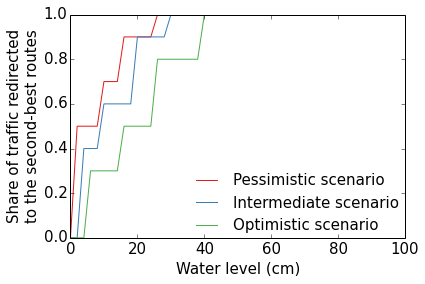

In [51]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,4))

xx = range(0,100,2)
plt.plot(xx,[steps(i,2) for i in xx],label="Pessimistic scenario",color="#e41a1c")
plt.plot(xx,[steps(i,1) for i in xx],label="Intermediate scenario",color="#377eb8")
plt.plot(xx,[steps(i,0) for i in xx],label="Optimistic scenario",color="#4daf4a")



plt.xlabel("Water level (cm)")
plt.ylabel("Share of traffic redirected\nto the second-best routes")
plt.legend(bbox_to_anchor=[0.52,-0.15,0.5,0.5],frameon=False,fontsize=15)
plt.savefig("traffic_scenarios.png",bbox_inches="tight",dpi=400)

The function below creates the function between water level and duration of the disruption

In [44]:
from scipy.interpolate import InterpolatedUnivariateSpline
def days(length):
    s = InterpolatedUnivariateSpline([0, 5, 30, 50, 200], [0,3*length,15*length,40*length,365*length], k=1)
    return s

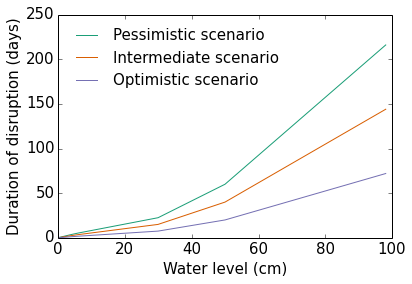

In [50]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,4))

xx = range(0,100,2)
s=days(1.5)
plt.plot(xx,[s(i,0) for i in xx],label="Pessimistic scenario",color='#1b9e77')
s=days(1)
plt.plot(xx,[s(i,0) for i in xx],label="Intermediate scenario",color='#d95f02')
s2=days(0.5)
plt.plot(xx,[s2(i,0) for i in xx],label="Optimistic scenario",color='#7570b3')

plt.xlabel("Water level (cm)")
plt.ylabel("Duration of disruption (days)")
plt.legend(bbox_to_anchor=[0.2,0.5,0.5,0.5],frameon=False,fontsize=15)
plt.savefig("duration_scenarios.png",bbox_inches="tight",dpi=400)

Here I hard coded the costs of reconstruction and rehabilitation based on the Columbian data

In [55]:
info_links.loc[[124, 418, 421, 720],"reconstruction"]=783225.0174
info_links.loc[[124, 418, 421, 720],"rehabilitation"]=359061.4644

In [56]:
info_links.loc[[124, 418],['STATUS', 'TERRAIN', 'SURFACE1', 'COND1', 'CLASS',"reconstruction","rehabilitation"]]\
.to_csv("conditions.csv")

This function calculates expected annual losses based on losses per return period

In [57]:
def annual_losses(expected_losses,losses_col):
    '''
    Calculates expected annual losses based on losses per return period event.
    '''
    cost=expected_losses.copy()
    #keeps the last two points for extrapolation
    #sorts rows by return period
    cost.sort(columns='RP', inplace=True)
    cost.index=range(len(cost))
    cost['frequency']=1/cost['RP']
    #calculates the integral using the trapeze method
    inte=0
    for i in range(1,len(cost)):
        trapeze =(cost.loc[i-1,'frequency']-cost.loc[i,'frequency'])*(cost.loc[i,losses_col]+cost.loc[i-1,losses_col])/2
        inte += trapeze
    inte += cost.loc[len(cost)-1,losses_col]*cost.loc[len(cost)-1,'frequency']
    return inte

This function calculates the total losses for a given water level

In [58]:
def totcost(link,cm,s,all_costs,redirection,km,reconstruction,rehabilitation):
    tot = s(cm)*(all_costs.loc[link,"full_disruption"]*(steps(cm,redirection))+\
    all_costs.loc[link,"partial_disruption"]*(1-steps(cm,redirection)))
    redirect_during_work = 0.1*(1+redirection)
    if s(cm)>7:
        tot += reconstruction*km + 30*km*((1-redirect_during_work)*all_costs.loc[link,"partial_disruption"]+\
                                          redirect_during_work*all_costs.loc[link,"full_disruption"])
    else:
        tot += rehabilitation*km + 10*km*((1-redirect_during_work)*all_costs.loc[link,"partial_disruption"]+\
                                          redirect_during_work*all_costs.loc[link,"full_disruption"])
    return tot 

This function calculates everything

In [59]:
def expected_annual_losses(link,col,costs_all,partial_costs_all,climat,redirection,length):
    s = days(length)
    all_costs = choose_costs(costs_all,partial_costs_all,col,link)
    summarize_costs = DataFrame(columns=["RP","cost"])
    for rp in [5,10,25,50,100,250,500,1000]:
        cm = info_links.ix[info_links.ScenarioID==link,climat+'_RP'+str(rp)+' (cm)'].values[0]
        km = info_links.ix[info_links.ScenarioID==link,'KM'].values[0]
        reconstruction = info_links.ix[info_links.ScenarioID==link,'reconstruction'].values[0]
        rehabilitation = info_links.ix[info_links.ScenarioID==link,'rehabilitation'].values[0]
        summarize_costs.loc[len(summarize_costs),:]=[rp,totcost(link,cm,s,\
                                                                all_costs,\
                                                                redirection,km,\
                                                               reconstruction,rehabilitation)]
    out = annual_losses(summarize_costs,"cost")                                       
    return out

This function runs all scenarios

In [133]:
def run_scenarios(link,col):
    out = DataFrame(columns=['redirection','climat','smallrucincrease','length','exp_annual_losses'])

    for redirection in [0,1,2]:
        for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
            for smallrucincrease in [0, 1]:
                for length in [1.5,1,0.5]:
                    out.loc[len(out),:]=[redirection,climat,int(smallrucincrease),length,\
                                     10**(-6)*expected_annual_losses(link,col,costs_all,get_partial_costs(smallrucincrease),\
                                                            climat,redirection,length)]
    return out

## Analysis for link 418

In [134]:
link = 418
col = "max cost with traffic (usd)"
out = run_scenarios(link,col)

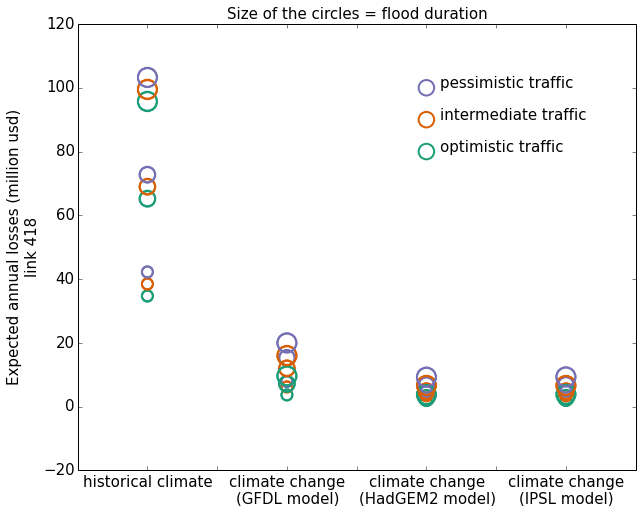

In [242]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)
j=0

sizes = [120*(i+1.) for i in range(3)]
labels = list()
for dur in ["optimistic","intermediate","pessimistic"]:
    labels.append("{} duration".format(dur))

for climat in ['EU_historical']:
    subout = out.ix[out.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    j+=1
        
for climat in ['GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    subout = out.ix[out.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    
    #ax.scatter([i]*len(subout.ix[subout.redirection==2,'exp_annual_losses']),subout.ix[subout.redirection==2,'exp_annual_losses'],\
         #marker='o',s=100*subout.ix[subout.redirection==2,'length'],facecolors='none',edgecolors='#e41a1c',alpha=0.5)
    j+=1
    
ax.scatter([j-2],[1*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#7570b3',linewidth='2')
ax.annotate("pessimistic traffic",xy=(j-1.9,1*10**(2)))
ax.scatter([j-2],[0.9*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#d95f02',linewidth='2')
ax.annotate("intermediate traffic",xy=(j-1.9,0.9*10**(2)))
ax.scatter([j-2],[0.8*10**(2)],marker='o',s=2*120,facecolors='none',edgecolors='#1b9e77',linewidth='2')
ax.annotate("optimistic traffic",xy=(j-1.9,0.8*10**(2)))

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="historical climate"
labelsx[3]="climate change\n(GFDL model)"
labelsx[5]="climate change\n(HadGEM2 model)"
labelsx[7]="climate change\n(IPSL model)"

#ax.legend(bbox_to_anchor=[0.5,0.5,0.5,0.5])
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1],frameon=False)

ax.set_xticklabels(labelsx)

plt.title("Size of the circles = flood duration",size=15)
plt.ylabel("Expected annual losses (million usd) \nlink 418")

#plt.savefig("results_418.png",bbox_inches="tight",dpi=400)

### Interventions

Here I hard code intervention costs (in million usd)

In [175]:
intervention_costs = Series()
intervention_costs["maintenance"] = 10**(-6)*70089.18
intervention_costs["flood_proof"] = 10**(-6)*1283832.70
intervention_costs["improvement"] = 10**(-6)*500607.68

This function calculates the NPVs of the three possible interventions

In [265]:
def calc_all_npv(years,info_links,out,link,intervention_costs):
    def f(x):
        diff=x.ix[x.length==1.5,"exp_annual_losses"].values[0]\
        -x.ix[x.length==0.5,"exp_annual_losses"].values[0]
        return diff
    
    disc_fact = np.array([1/(1.05)**i for i in range(1,years+1)])
        
    reduce_duration = out.groupby(["redirection","climat","smallrucincrease"]).apply(lambda x:f(x))
    disc_reduce_duration = [sum(np.array(30*[l])*disc_fact) for l in reduce_duration]
   
    maintenance = sum(np.array(years*[intervention_costs.maintenance*info_links.loc[link,"KM"]])*disc_fact)
    npv_maintenance = disc_reduce_duration-maintenance
    
    maintenance2ndbest = np.array(years*[intervention_costs.maintenance*costs_all.loc[link,"max km difference"]])*disc_fact
    flood_proof = intervention_costs.flood_proof*info_links.loc[link,"KM"]+maintenance
    redundancy = costs_all.loc[link,"max km difference"]*intervention_costs.improvement+sum(maintenance2ndbest)
    disc_losses = [sum(np.array(30*[l])*disc_fact) for l in out.exp_annual_losses]
    npv_flood_proof = disc_losses-flood_proof
    npv_redunduncy = disc_losses-redundancy
    return disc_losses,npv_maintenance,npv_flood_proof,npv_redunduncy

I calculate the NPVs with different cost increase factors

In [266]:
years = 30
disc_losses,npv_maintenance0,npv_flood_proof0,npv_redunduncy0 = calc_all_npv(years,info_links,out,418,intervention_costs)
disc_losses,npv_maintenance1,npv_flood_proof1,npv_redunduncy1 = calc_all_npv(years,info_links,out,418,intervention_costs*1.5)
disc_losses,npv_maintenance2,npv_flood_proof2,npv_redunduncy2 = calc_all_npv(years,info_links,out,418,intervention_costs*2)

npv_maintenance = np.concatenate((npv_maintenance0,npv_maintenance1,npv_maintenance2),axis=0)
npv_flood_proof = np.concatenate((npv_flood_proof0,npv_flood_proof1,npv_flood_proof2),axis=0)
npv_redunduncy = np.concatenate((npv_redunduncy0,npv_redunduncy1,npv_redunduncy2),axis=0)

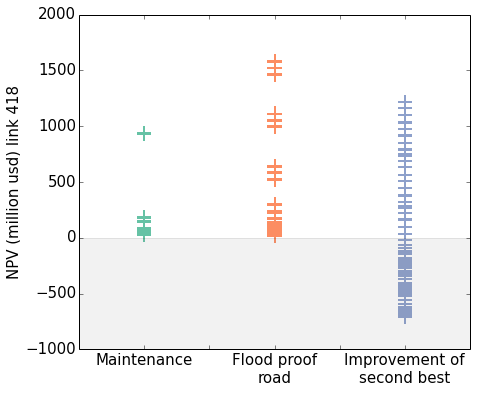

In [260]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,6))

ax=plt.subplot(111)

ax.scatter([0]*len(npv_maintenance),npv_maintenance,\
                 marker='+',s=200,facecolors='none',edgecolors='#66c2a5',linewidth='2')

ax.scatter([1]*len(npv_flood_proof),npv_flood_proof,\
                 marker='+',s=200,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([2]*len(npv_redunduncy),npv_redunduncy,\
                 marker='+',s=200,facecolors='none',edgecolors='#8da0cb',linewidth='2')
    
ax.fill_between(np.arange(-1,4,1), 0, -1000, facecolor='grey', alpha=0.1)
ax.set_xlim([-0.5,2.5])
ax.set_ylim([-1000,2000])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="Maintenance"
labelsx[3]="Flood proof\nroad"
labelsx[5]="Improvement of\nsecond best"


ax.set_xticklabels(labelsx)
plt.ylabel("NPV (million usd) link 418")

#plt.savefig("NPV_418.png",bbox_inches="tight",dpi=400)

Here I calculate regret

In [267]:
print(-min(npv_flood_proof)/max(disc_losses))
print(-min(npv_maintenance)/max(disc_losses))
print(-min(npv_redunduncy)/max(disc_losses))

-0.0111319513468
-0.0145973266501
0.447081137031


In [257]:
print(-min(npv_flood_proof))
print(-min(npv_maintenance))
print(-min(npv_redunduncy))

-17.6770334045
-7.71517394611
709.944550385


## Analysis for link 124

In [215]:
link = 124
col = "max cost with traffic (usd)"
out4 = run_scenarios(link,col)

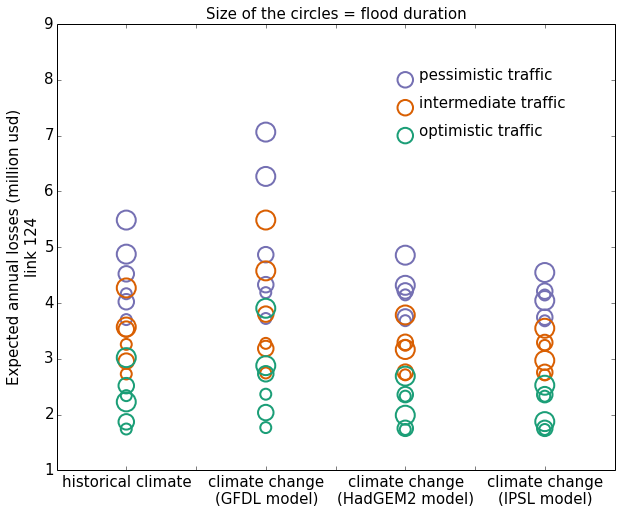

In [244]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)
j=0

sizes = [120*(i+1.) for i in range(3)]
labels = list()
for dur in ["optimistic","intermediate","pessimistic"]:
    labels.append("{} duration".format(dur))

for climat in ['EU_historical']:
    subout = out4.ix[out4.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    j+=1
        
for climat in ['GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
    subout = out4.ix[out4.climat==climat,:]
    grouped = subout.groupby("length")
    for i, (name, group) in enumerate(grouped):
        ax.scatter([j]*len(group.ix[group.redirection==0,'exp_annual_losses']),group.ix[group.redirection==0,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#1b9e77',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==1,'exp_annual_losses']),group.ix[group.redirection==1,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#d95f02',linewidth='2')
        ax.scatter([j]*len(group.ix[group.redirection==2,'exp_annual_losses']),group.ix[group.redirection==2,'exp_annual_losses'],\
                 marker='o',s=sizes[i],facecolors='none',edgecolors='#7570b3',linewidth='2')
    
    #ax.scatter([i]*len(subout.ix[subout.redirection==2,'exp_annual_losses']),subout.ix[subout.redirection==2,'exp_annual_losses'],\
         #marker='o',s=100*subout.ix[subout.redirection==2,'length'],facecolors='none',edgecolors='#e41a1c',alpha=0.5)
    j+=1
    
ax.scatter([j-2],[0.8*10**(1)],marker='o',s=2*120,facecolors='none',edgecolors='#7570b3',linewidth='2')
ax.annotate("pessimistic traffic",xy=(j-1.9,0.8*10**(1)))
ax.scatter([j-2],[0.75*10**(1)],marker='o',s=2*120,facecolors='none',edgecolors='#d95f02',linewidth='2')
ax.annotate("intermediate traffic",xy=(j-1.9,0.75*10**(1)))
ax.scatter([j-2],[0.7*10**(1)],marker='o',s=2*120,facecolors='none',edgecolors='#1b9e77',linewidth='2')
ax.annotate("optimistic traffic",xy=(j-1.9,0.7*10**(1)))

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="historical climate"
labelsx[3]="climate change\n(GFDL model)"
labelsx[5]="climate change\n(HadGEM2 model)"
labelsx[7]="climate change\n(IPSL model)"

#ax.legend(bbox_to_anchor=[0.5,0.5,0.5,0.5])
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1],frameon=False)

ax.set_xticklabels(labelsx)

plt.title("Size of the circles = flood duration",size=15)
plt.ylabel("Expected annual losses (million usd) \nlink 124")

plt.savefig("results_124.png",bbox_inches="tight",dpi=400)

In [268]:
years = 30
disc_losses,npv_maintenance0,npv_flood_proof0,npv_redunduncy0 = calc_all_npv(years,info_links,out4,124,intervention_costs)
disc_losses,npv_maintenance1,npv_flood_proof1,npv_redunduncy1 = calc_all_npv(years,info_links,out4,124,intervention_costs*1.5)
disc_losses,npv_maintenance2,npv_flood_proof2,npv_redunduncy2 = calc_all_npv(years,info_links,out4,124,intervention_costs*2)

npv_maintenance = np.concatenate((npv_maintenance0,npv_maintenance1,npv_maintenance2),axis=0)
npv_flood_proof = np.concatenate((npv_flood_proof0,npv_flood_proof1,npv_flood_proof2),axis=0)
npv_redunduncy = np.concatenate((npv_redunduncy0,npv_redunduncy1,npv_redunduncy2),axis=0)

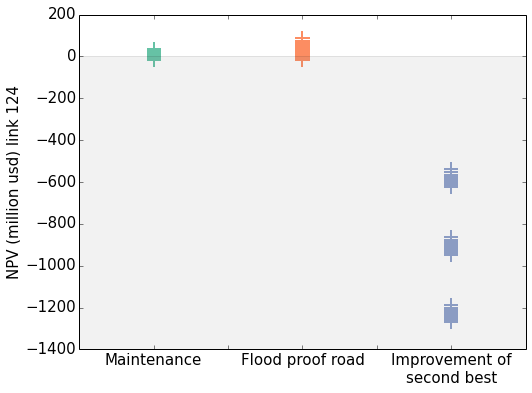

In [246]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

ax.scatter([0]*len(npv_maintenance),npv_maintenance,\
                 marker='+',s=200,facecolors='none',edgecolors='#66c2a5',linewidth='2')

ax.scatter([1]*len(npv_flood_proof),npv_flood_proof,\
                 marker='+',s=200,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([2]*len(npv_redunduncy),npv_redunduncy,\
                 marker='+',s=200,facecolors='none',edgecolors='#8da0cb',linewidth='2')
    
ax.fill_between(np.arange(-1,4,1), 0, -1400, facecolor='grey', alpha=0.1)
ax.set_xlim([-0.5,2.5])
ax.set_ylim([-1400,200])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="Maintenance"
labelsx[3]="Flood proof road"
labelsx[5]="Improvement of\nsecond best"


ax.set_xticklabels(labelsx)
plt.ylabel("NPV (million usd) link 124")

plt.savefig("NPV_124.png",bbox_inches="tight",dpi=400)

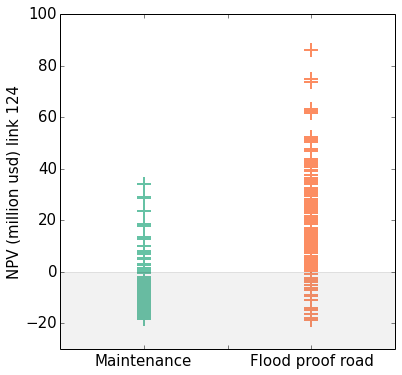

In [247]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,6))

ax=plt.subplot(111)

ax.scatter([0]*len(npv_maintenance),npv_maintenance,\
                 marker='+',s=200,facecolors='none',edgecolors='#66c2a5',linewidth='2')

ax.scatter([1]*len(npv_flood_proof),npv_flood_proof,\
                 marker='+',s=200,facecolors='none',edgecolors='#fc8d62',linewidth='2')
    
ax.fill_between(np.arange(-1,3,1), 0, -1400, facecolor='grey', alpha=0.1)
ax.set_xlim([-0.5,1.5])
ax.set_ylim([-30,100])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="Maintenance"
labelsx[3]="Flood proof road"


ax.set_xticklabels(labelsx)
plt.ylabel("NPV (million usd) link 124")

plt.savefig("NPV_124_2.png",bbox_inches="tight",dpi=400)

In [269]:
print(-min(npv_flood_proof)/max(disc_losses))
print(-min(npv_maintenance)/max(disc_losses))
print(-min(npv_redunduncy)/max(disc_losses))

0.172002685422
0.170529130371
11.7063293306


In [223]:
print(-min(npv_flood_proof))
print(-min(npv_maintenance))
print(-min(npv_redunduncy))

18.6750565642
18.515066481
1271.00551873
